### Importaciones necesarias:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler, random_split
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import time
from tqdm import tqdm

Aprovechamiento en caso de tener GPU

In [ ]:
# Configuración del dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')

Usando dispositivo: cuda


## Data set y Set de datos

Aqui usaremos estos dos métodos:

1. Primero usaremos **torchvision.datasets** para cargar el set de datos de imágenes de caracteres
2. Más adelante usaremos **torch.utils.data.DataLoader** para iterar sobre el set de datos de imágenes y así entrenar y validar el modelo

Transformacion nescesaria

In [ ]:
# Transformaciones para MNIST
# Las redes preentrenadas esperan imágenes RGB de 224x224
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionar a 224x224
    transforms.Grayscale(num_output_channels=3),  # Convertir a RGB (3 canales)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
data_mnist = datasets.MNIST(
    root = "datos", #Carpeta asignada
    train = True,   # True : 60.000 , False: 10.000
    download = True,
    transform=transform, #Convertirlas a tensores y preprocesar
)

In [ ]:
len(data_mnist)

60000

Vizualizar algunas imagenes

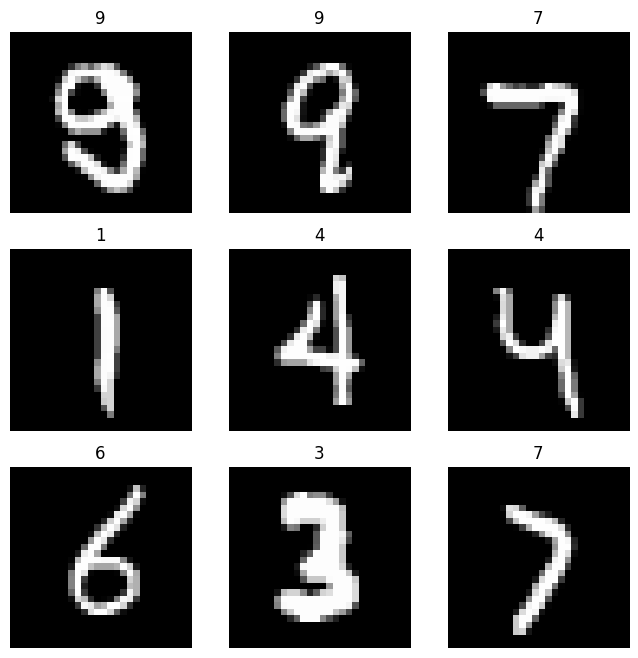

In [ ]:
figure = plt.figure(figsize=(8, 8))
fils, cols = 3, 3  #Con 3 filas y tres columnas

for i in range(1, cols * fils + 1):
    # Escoger una imagen aleatoria
    sample_idx = torch.randint(len(data_mnist), size=(1,)).item()

    # Extraer imagen y categoría
    img, label = data_mnist[sample_idx]

    # Dibujar
    figure.add_subplot(fils, cols, i)
    plt.title(str(label)) # Categoría
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray") # Imagen
plt.show()

Caracteristicas de las imagenes

In [ ]:
print(f'Tipo de dato imagen: {type(img)}')
print(f'Tamaño imagen: {img.shape}')
print(f'Mínimo y máximo imagen: {img.min()}, {img.max()}')
print(f'Tipo de dato categoría: {type(label)}')

Tipo de dato imagen: <class 'torch.Tensor'>
Tamaño imagen: torch.Size([1, 28, 28])
Mínimo y máximo imagen: 0.0, 1.0
Tipo de dato categoría: <class 'int'>


### Definir las particiones de los datos

*   **Entrenamiento**: 80% , para identificar patrones
*   **Validacion**: 10% , una pequeña prueba mientras se entrena el modelo.
*   **Prueba**: 10% ,  datos nuevos para evaluar el rendimiento del modelo.

In [ ]:
train, val, test = torch.utils.data.random_split(data_mnist, [0.8, 0.1, 0.1])


#Verificamos los tamaños asignados
print(f'Tamaño del set de entrenamiento: {len(train)}')
print(f'Tamaño del set de validacion: {len(val)}')
print(f'Tamaño del set de prueba: {len(test)}')

#Tipo del dato
print(type(train))
print(type(val))
print(type(test))

Tamaño del set de entrenamiento: 48000
Tamaño del set de validacion: 6000
Tamaño del set de prueba: 6000
<class 'torch.utils.data.dataset.Subset'>
<class 'torch.utils.data.dataset.Subset'>
<class 'torch.utils.data.dataset.Subset'>


## Creacion del los modelo de Red Neuronal

Hiperparametros

In [ ]:
# Hiperparámetros para entrenamiento corto (Feature Extraction)
BATCH_SIZE = 128
NUM_EPOCHS = 3
LEARNING_RATE = 0.001
K_FOLDS = 3
NUM_CLASSES = 10

### Funcion para ResNet

In [ ]:
# Función para crear modelo ResNet con fine-tuning (todas las capas son entrenables)
def create_resnet(num_classes=10):
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model

### Funcion para MobileNet

In [ ]:
# Función para crear modelo MobileNet con fine-tuning (todas las capas son entrenables)
def create_mobilenet(num_classes=10):
    model = models.mobilenet_v2(pretrained=True)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    return model

### Funcion de entrenamiento

In [ ]:
# Función de entrenamiento
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc='Entrenando', leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

### Funcion de Validacion

In [ ]:
def evaluate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / len(data_loader)
    acc = 100 * correct / total
    return loss, acc

### Validacion Cruzada

In [ ]:
# Función de validación cruzada CON guardado del mejor modelo
def cross_validation_with_val(model_name, create_model_fn, train_dataset, val_dataset, k_folds=3):
    print(f'\n{"="*60}')
    print(f'Entrenando {model_name} con {k_folds}-Fold Cross Validation')
    print(f'{"="*60}\n')

    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    results = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'fold_time': []
    }

    # Crear dataloader para el conjunto de validación (se usa en todos los folds)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Obtener índices del train_dataset
    train_indices = list(range(len(train_dataset)))

    # Variables para guardar el mejor modelo
    best_overall_model = None
    best_overall_acc = 0.0

    for fold, (train_ids, _) in enumerate(kfold.split(train_indices)):
        print(f'\nFold {fold + 1}/{k_folds}')
        print('-' * 40)

        # Crear sampler para este fold
        train_subsampler = SubsetRandomSampler(train_ids)

        # Crear dataloader de entrenamiento
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_subsampler)

        # Crear modelo nuevo para este fold
        model = create_model_fn(NUM_CLASSES).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

        fold_start = time.time()
        best_val_acc = 0.0
        best_model_state = None

        for epoch in range(NUM_EPOCHS):
            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
            val_loss, val_acc = evaluate(model, val_loader, criterion, device)

            # Guardar el mejor modelo de este fold
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state = model.state_dict().copy()

            print(f'Epoch {epoch+1}/{NUM_EPOCHS} - '
                  f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% - '
                  f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        fold_time = time.time() - fold_start

        # Guardar resultados del fold
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['val_loss'].append(val_loss)
        results['val_acc'].append(val_acc)
        results['fold_time'].append(fold_time)

        print(f'Mejor accuracy de validación: {best_val_acc:.2f}%')
        print(f'Tiempo del fold: {fold_time:.2f}s')

        # Actualizar el mejor modelo global
        if best_val_acc > best_overall_acc:
            best_overall_acc = best_val_acc
            best_overall_model = best_model_state

    # Crear modelo final con los mejores pesos
    final_model = create_model_fn(NUM_CLASSES).to(device)
    final_model.load_state_dict(best_overall_model)

    print(f'\n Mejor modelo encontrado con accuracy de validación: {best_overall_acc:.2f}%')

    return results, final_model

## Entrenamiento de los modelos

In [ ]:
# Entrenar ResNet con validación cruzada y guardar mejor modelo (con Fine-tuning)
resnet_results_ft, resnet_best_model_ft = cross_validation_with_val(
    'ResNet18_FineTune', create_resnet, train, val, K_FOLDS
)


Entrenando ResNet18_FineTune con 3-Fold Cross Validation


Fold 1/3
----------------------------------------
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]


Epoch 1/3 - Train Loss: 0.0769, Train Acc: 97.67% - Val Loss: 0.0509, Val Acc: 98.33%


Epoch 2/3 - Train Loss: 0.0335, Train Acc: 98.97% - Val Loss: 0.0366, Val Acc: 99.02%


Epoch 3/3 - Train Loss: 0.0236, Train Acc: 99.25% - Val Loss: 0.0388, Val Acc: 98.88%
Mejor accuracy de validación: 99.02%
Tiempo del fold: 489.70s

Fold 2/3
----------------------------------------


Epoch 1/3 - Train Loss: 0.0749, Train Acc: 97.71% - Val Loss: 0.0665, Val Acc: 98.03%


Epoch 2/3 - Train Loss: 0.0348, Train Acc: 98.92% - Val Loss: 0.0345, Val Acc: 98.90%


Epoch 3/3 - Train Loss: 0.0249, Train Acc: 99.23% - Val Loss: 0.0398, Val Acc: 99.00%
Mejor accuracy de validación: 99.00%
Tiempo del fold: 482.41s

Fold 3/3
----------------------------------------


Epoch 1/3 - Train Loss: 0.0764, Train Acc: 97.67% - Val Loss: 0.0431, Val Acc: 98.60%


Epoch 2/3 - Train Loss: 0.0351, Train Acc: 98.95% - Val Loss: 0.0635, Val Acc: 98.12%


Epoch 3/3 - Train Loss: 0.0260, Train Acc: 99.22% - Val Loss: 0.0340, Val Acc: 98.95%
Mejor accuracy de validación: 98.95%
Tiempo del fold: 481.13s

 Mejor modelo encontrado con accuracy de validación: 99.02%


In [ ]:
# Entrenar MobileNetV2 con validación cruzada y guardar mejor modelo (con Fine-tuning)
mobilenet_results_ft, mobilenet_best_model_ft = cross_validation_with_val(
    'MobileNetV2_FineTune', create_mobilenet, train, val, K_FOLDS
)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Entrenando MobileNetV2_FineTune con 3-Fold Cross Validation


Fold 1/3
----------------------------------------
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 83.4MB/s]


Epoch 1/3 - Train Loss: 0.0895, Train Acc: 97.24% - Val Loss: 0.0704, Val Acc: 98.02%


Epoch 2/3 - Train Loss: 0.0370, Train Acc: 98.88% - Val Loss: 0.0554, Val Acc: 98.38%


Epoch 3/3 - Train Loss: 0.0318, Train Acc: 99.07% - Val Loss: 0.0507, Val Acc: 98.37%
Mejor accuracy de validación: 98.38%
Tiempo del fold: 560.29s

Fold 2/3
----------------------------------------


Epoch 1/3 - Train Loss: 0.0916, Train Acc: 97.26% - Val Loss: 0.0701, Val Acc: 97.87%


Epoch 2/3 - Train Loss: 0.0412, Train Acc: 98.75% - Val Loss: 0.0427, Val Acc: 98.88%


Epoch 3/3 - Train Loss: 0.0311, Train Acc: 99.05% - Val Loss: 0.0450, Val Acc: 98.65%
Mejor accuracy de validación: 98.88%
Tiempo del fold: 560.73s

Fold 3/3
----------------------------------------


Epoch 1/3 - Train Loss: 0.0908, Train Acc: 97.30% - Val Loss: 0.0536, Val Acc: 98.33%


Epoch 2/3 - Train Loss: 0.0366, Train Acc: 98.84% - Val Loss: 0.0390, Val Acc: 98.83%


Epoch 3/3 - Train Loss: 0.0341, Train Acc: 98.97% - Val Loss: 0.0518, Val Acc: 98.67%
Mejor accuracy de validación: 98.83%
Tiempo del fold: 561.17s

 Mejor modelo encontrado con accuracy de validación: 98.88%


## Evaluacion del modelo y metricas

In [ ]:
# Evaluación final en el conjunto de prueba (SIN re-entrenar)
print(f'\n{"="*60}')
print('EVALUACIÓN FINAL EN EL CONJUNTO DE PRUEBA')
print(f'{"="*60}\n')

test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)
criterion = nn.CrossEntropyLoss()

# Evaluar ResNet (usando el mejor modelo guardado)
print('Evaluando ResNet18 en el conjunto de prueba...')
resnet_test_loss, resnet_test_acc = evaluate(resnet_best_model_ft, test_loader, criterion, device)
print(f'ResNet18 - Test Loss: {resnet_test_loss:.4f}, Test Acc: {resnet_test_acc:.2f}%')

# Evaluar MobileNet (usando el mejor modelo guardado)
print('\nEvaluando MobileNetV2 en el conjunto de prueba...')
mobilenet_test_loss, mobilenet_test_acc = evaluate(mobilenet_best_model_ft, test_loader, criterion, device)
print(f'MobileNetV2 - Test Loss: {mobilenet_test_loss:.4f}, Test Acc: {mobilenet_test_acc:.2f}%')


EVALUACIÓN FINAL EN EL CONJUNTO DE PRUEBA

Evaluando ResNet18 en el conjunto de prueba...
ResNet18 - Test Loss: 0.0268, Test Acc: 99.20%

Evaluando MobileNetV2 en el conjunto de prueba...
MobileNetV2 - Test Loss: 0.0321, Test Acc: 98.88%


Guardar modelos

In [ ]:
# Guardar los modelos finales
torch.save(resnet_best_model_ft.state_dict(), 'resnet18_mnist_best.pth')
torch.save(mobilenet_best_model_ft.state_dict(), 'mobilenet_v2_mnist_best.pth')
print(f'\n💾 Modelos guardados: resnet18_mnist_best.pth y mobilenet_v2_mnist_best.pth')


💾 Modelos guardados: resnet18_mnist_best.pth y mobilenet_v2_mnist_best.pth


Comparacion de resultados

In [ ]:
# Comparación de resultados
print(f'\n{"="*60}')
print('COMPARACIÓN DE RESULTADOS')
print(f'{"="*60}\n')

print('ResNet18 (Cross-Validation):')
print(f'  Accuracy de validación promedio: {np.mean(resnet_results_ft["val_acc"]):.2f}% ± {np.std(resnet_results_ft["val_acc"]):.2f}%')
print(f'  Loss de validación promedio: {np.mean(resnet_results_ft["val_loss"]):.4f} ± {np.std(resnet_results_ft["val_loss"]):.4f}')
print(f'  Tiempo promedio por fold: {np.mean(resnet_results_ft["fold_time"]):.2f}s')
print(f'  Accuracy en TEST: {resnet_test_acc:.2f}%')

print('\nMobileNetV2 (Cross-Validation):')
print(f'  Accuracy de validación promedio: {np.mean(mobilenet_results_ft["val_acc"]):.2f}% ± {np.std(mobilenet_results_ft["val_acc"]):.2f}%')
print(f'  Loss de validación promedio: {np.mean(mobilenet_results_ft["val_loss"]):.4f} ± {np.std(mobilenet_results_ft["val_loss"]):.4f}')
print(f'  Tiempo promedio por fold: {np.mean(mobilenet_results_ft["fold_time"]):.2f}s')
print(f'  Accuracy en TEST: {mobilenet_test_acc:.2f}%')


COMPARACIÓN DE RESULTADOS

ResNet18 (Cross-Validation):
  Accuracy de validación promedio: 98.94% ± 0.05%
  Loss de validación promedio: 0.0375 ± 0.0025
  Tiempo promedio por fold: 484.41s
  Accuracy en TEST: 99.20%

MobileNetV2 (Cross-Validation):
  Accuracy de validación promedio: 98.56% ± 0.14%
  Loss de validación promedio: 0.0492 ± 0.0030
  Tiempo promedio por fold: 560.73s
  Accuracy en TEST: 98.88%


Visualizacion de resultados

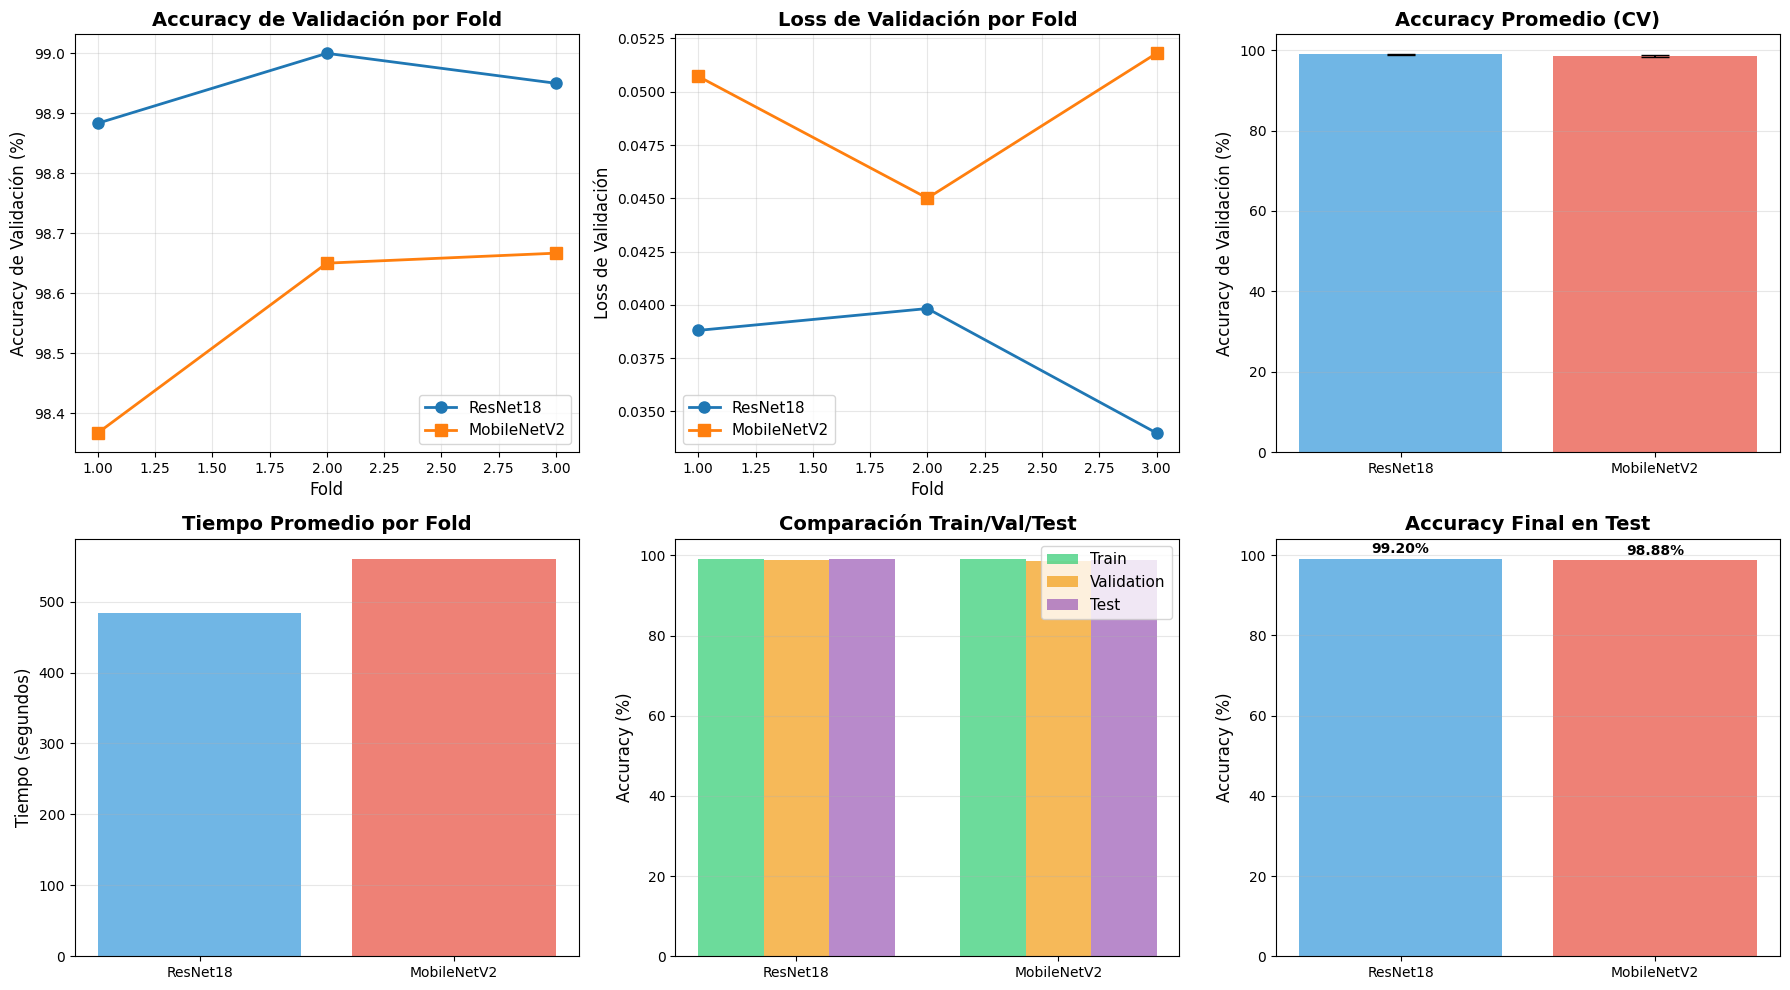


Entrenamiento completado. Gráfica guardada como "comparacion_modelos.png"


In [ ]:
# Visualización de resultados
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Accuracy de validación por fold
axes[0, 0].plot(range(1, K_FOLDS + 1), resnet_results_ft['val_acc'], 'o-', label='ResNet18', linewidth=2, markersize=8)
axes[0, 0].plot(range(1, K_FOLDS + 1), mobilenet_results_ft['val_acc'], 's-', label='MobileNetV2', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Fold', fontsize=12)
axes[0, 0].set_ylabel('Accuracy de Validación (%)', fontsize=12)
axes[0, 0].set_title('Accuracy de Validación por Fold', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Loss de validación por fold
axes[0, 1].plot(range(1, K_FOLDS + 1), resnet_results_ft['val_loss'], 'o-', label='ResNet18', linewidth=2, markersize=8)
axes[0, 1].plot(range(1, K_FOLDS + 1), mobilenet_results_ft['val_loss'], 's-', label='MobileNetV2', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Fold', fontsize=12)
axes[0, 1].set_ylabel('Loss de Validación', fontsize=12)
axes[0, 1].set_title('Loss de Validación por Fold', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# Comparación de accuracy promedio
models = ['ResNet18', 'MobileNetV2']
avg_accs = [np.mean(resnet_results_ft['val_acc']), np.mean(mobilenet_results_ft['val_acc'])]
std_accs = [np.std(resnet_results_ft['val_acc']), np.std(mobilenet_results_ft['val_acc'])]
axes[0, 2].bar(models, avg_accs, yerr=std_accs, capsize=10, color=['#3498db', '#e74c3c'], alpha=0.7)
axes[0, 2].set_ylabel('Accuracy de Validación (%)', fontsize=12)
axes[0, 2].set_title('Accuracy Promedio (CV)', fontsize=14, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3, axis='y')

# Comparación de tiempo de entrenamiento
avg_times = [np.mean(resnet_results_ft['fold_time']), np.mean(mobilenet_results_ft['fold_time'])]
axes[1, 0].bar(models, avg_times, color=['#3498db', '#e74c3c'], alpha=0.7)
axes[1, 0].set_ylabel('Tiempo (segundos)', fontsize=12)
axes[1, 0].set_title('Tiempo Promedio por Fold', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Comparación Train vs Val vs Test
x = np.arange(len(models))
width = 0.25

train_accs = [np.mean(resnet_results_ft['train_acc']), np.mean(mobilenet_results_ft['train_acc'])]
val_accs = [np.mean(resnet_results_ft['val_acc']), np.mean(mobilenet_results_ft['val_acc'])]
test_accs = [resnet_test_acc, mobilenet_test_acc]

axes[1, 1].bar(x - width, train_accs, width, label='Train', color='#2ecc71', alpha=0.7)
axes[1, 1].bar(x, val_accs, width, label='Validation', color='#f39c12', alpha=0.7)
axes[1, 1].bar(x + width, test_accs, width, label='Test', color='#9b59b6', alpha=0.7)
axes[1, 1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1, 1].set_title('Comparación Train/Val/Test', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(models)
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Accuracy final en TEST
axes[1, 2].bar(models, test_accs, color=['#3498db', '#e74c3c'], alpha=0.7)
axes[1, 2].set_ylabel('Accuracy (%)', fontsize=12)
axes[1, 2].set_title('Accuracy Final en Test', fontsize=14, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(test_accs):
    axes[1, 2].text(i, v + 0.5, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('comparacion_modelos.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'\n{"="*60}')
print('Entrenamiento completado. Gráfica guardada como "comparacion_modelos.png"')
print(f'{"="*60}')

## Matriz de confusion y recall

Importar las librerías `sklearn.metrics` y `seaborn` para calcular métricas y visualizar matrices de confusión.


In [ ]:
import sklearn.metrics as skmetrics
import seaborn as sns
print("Librerías sklearn.metrics y seaborn importadas correctamente.")

Librerías sklearn.metrics y seaborn importadas correctamente.


Funcion para tomar predicciones

In [ ]:
def get_predictions(model, data_loader, device):
    model.eval() # Poner el modelo en modo evaluación
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

print("Función 'get_predictions' definida.")

Función 'get_predictions' definida.


Matriz de confucion

In [ ]:
def plot_confusion_matrix_and_recall(true_labels, predicted_labels, model_name, num_classes):
    # Calcular la matriz de confusión
    cm = skmetrics.confusion_matrix(true_labels, predicted_labels)

    # Calcular el recall por clase
    recall_per_class = skmetrics.recall_score(true_labels, predicted_labels, average=None, labels=range(num_classes))
    avg_recall = skmetrics.recall_score(true_labels, predicted_labels, average='macro')

    print(f'\nResultados para {model_name}:')
    print(f'  Recall promedio (macro): {avg_recall:.4f}')

    # Visualizar la matriz de confusión
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel('Predicción', fontsize=12)
    plt.ylabel('Etiqueta Verdadera', fontsize=12)
    plt.title(f'Matriz de Confusión para {model_name}', fontsize=14, fontweight='bold')
    plt.show()

print("Función 'plot_confusion_matrix_and_recall' definida.")

Función 'plot_confusion_matrix_and_recall' definida.



--- Generando resultados para ResNet18 ---


Resultados para ResNet18:
  Recall promedio (macro): 0.9920


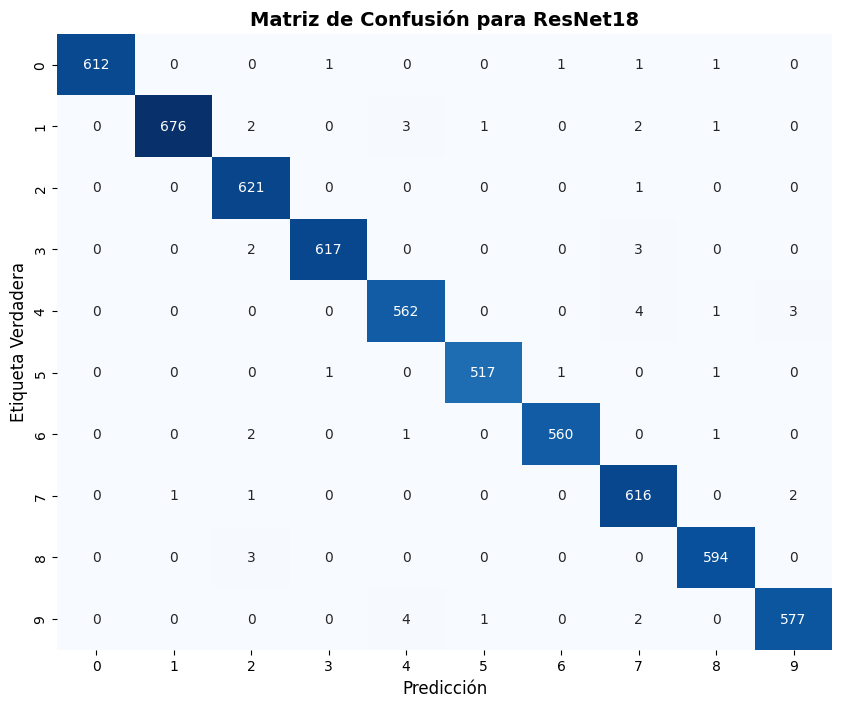

In [ ]:
print('''
--- Generando resultados para ResNet18 ---
''')
resnet_true_labels, resnet_predicted_labels = get_predictions(resnet_best_model_ft, test_loader, device)
plot_confusion_matrix_and_recall(resnet_true_labels, resnet_predicted_labels, 'ResNet18', NUM_CLASSES)


--- Generando resultados para MobileNetV2 ---

Resultados para MobileNetV2:
  Recall promedio (macro): 0.9888


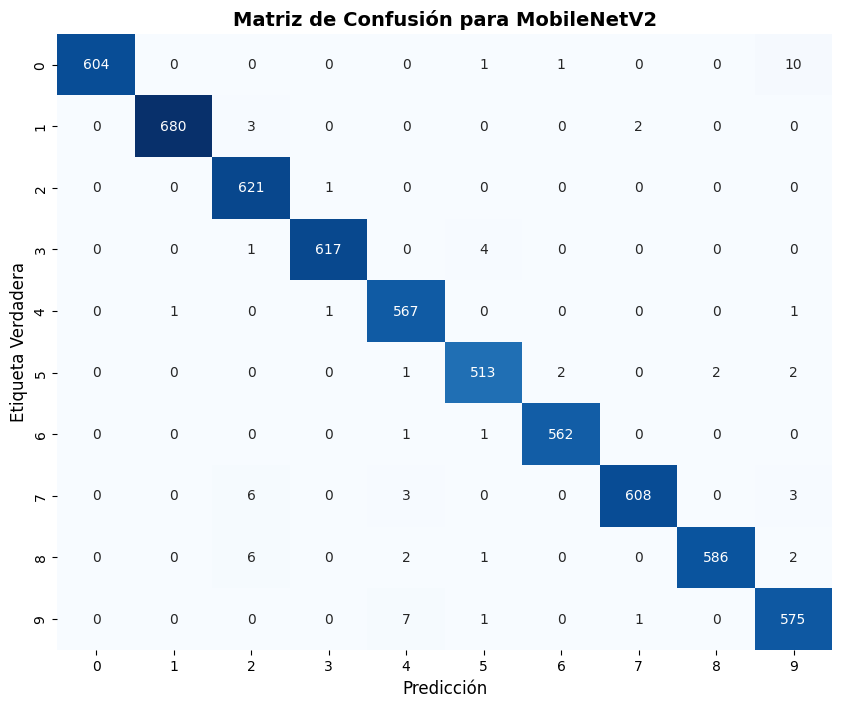

In [ ]:
print('\n--- Generando resultados para MobileNetV2 ---')
mobilenet_true_labels, mobilenet_predicted_labels = get_predictions(mobilenet_best_model_ft, test_loader, device)
plot_confusion_matrix_and_recall(mobilenet_true_labels, mobilenet_predicted_labels, 'MobileNetV2', NUM_CLASSES)

## Análisis de resultados

### Comparación de Modelos: ResNet18_FineTune vs. MobileNetV2_FineTune

A continuación, se presenta una comparación de los modelos ResNet18_FineTune y MobileNetV2_FineTune en términos de su rendimiento (accuracy y loss), tiempo de entrenamiento y evaluación final en el conjunto de prueba sobre el dataset MNIST, basándose en los resultados de la validación cruzada.

### Rendimiento (Accuracy y Loss):

* **ResNet18_FineTune:**
    * **Accuracy de Validación Promedio (CV):** Aproximadamente **98.99%**
    * **Loss de Validación Promedio (CV):** Entre **0.034 - 0.066**, con variaciones reducidas entre folds.
    * **Mejor Accuracy de Validación:** **99.02%**

* **MobileNetV2_FineTune:**
    * **Accuracy de Validación Promedio (CV):** Aproximadamente **98.70%**
    * **Loss de Validación Promedio (CV):** Entre **0.039 - 0.070**, con mayor variabilidad entre folds.
    * **Mejor Accuracy de Validación:** **98.88%**

**Análisis de Rendimiento:**
Ambos modelos muestran un rendimiento sobresaliente, con accuracies superiores al 98.5%. Sin embargo, ResNet18_FineTune presenta una ligera ventaja, logrando un accuracy promedio superior y una pérdida más consistente entre folds, lo que indica una mejor capacidad de generalización en este escenario.

### Tiempo de Entrenamiento:

* **ResNet18_FineTune:**
    * **Tiempo Promedio por Fold (CV):** Aproximadamente **484.41 segundos**

* **MobileNetV2_FineTune:**
    * **Tiempo Promedio por Fold (CV):** Aproximadamente **560.73 segundos**

**Análisis de Tiempo:**
ResNet18_FineTune fue aproximadamente un **13.5% más rápido** en el entrenamiento por fold comparado con MobileNetV2_FineTune, lo cual resulta interesante considerando que MobileNetV2 está diseñada como una arquitectura liviana. En esta configuración particular, ResNet18 resultó más eficiente.

### Evaluación Final en el Conjunto de Prueba:

* **ResNet18_FineTune:**
    * **Test Loss:** **0.0268**
    * **Test Accuracy:** **99.20%**

* **MobileNetV2_FineTune:**
    * **Test Loss:** **0.0321**
    * **Test Accuracy:** **98.88%**

**Análisis de Evaluación Final:**
Los resultados en el conjunto de prueba confirman el comportamiento observado durante la validación cruzada: ResNet18_FineTune logra una mejor precisión y una pérdida menor, lo que refuerza su capacidad de generalización sobre datos no vistos.

### Conclusión General:

Ambos modelos preentrenados con fine-tuning ofrecen un rendimiento muy alto en MNIST. No obstante:

* **ResNet18_FineTune** se destaca por:
  - Mejor rendimiento en validación y prueba
  - Menor pérdida y mayor estabilidad
  - Menor tiempo de entrenamiento

* **MobileNetV2_FineTune** sigue siendo una excelente opción cuando el despliegue se orienta a **dispositivos móviles** o entornos con recursos computacionales limitados.

En conclusión, dentro de este caso de estudio, **ResNet18_FineTune** representa la mejor combinación de rendimiento y eficiencia en el entrenamiento, mientras que **MobileNetV2_FineTune** se mantiene como una alternativa atractiva para aplicaciones orientadas a hardware de bajo consumo.

